# **Exploring dataset**

All data are taken from [Copernicus ERA5](https://climate.copernicus.eu/climate-reanalysis), which is a climatic dataset with high space-time resolution. All the data stored in ERA5 are obtained with reanalysis, i.e. by running the ECMWF meteorological model on real historical data. This allows to reconstruct the missing data and build a complete space-time 3D grid for each atmospheric variable on the entire globe from 1950 to today.

For each variable, our dataset is something like:


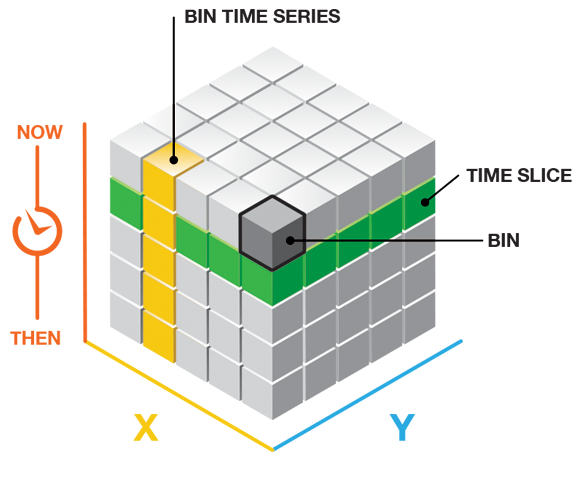 

Where in X and Y there are longitude and latitude. ERA5 has a spatial resolution of 0.25°x0.25° (more or less 30Km, but it strongly depends on the latitude), and a time resolution of 1 hour. 

In this project we will use *total prepititation* and *geopotential fields* at 3 different pressure levels: 500, 700 and 850 hPa. We will extract data only for winter (December, January, February) from 1980 to 2021. That because precipitations are connected to large-scale configuration only in this period, when convective motions (thunderstorms)  are absent. So our dataset has 15040 samples.

In this notebook we are using a sub-dataset of ... samples (from 2015 to 2021) in order to make computation faster.  

Geopotential fields cover a square area between *lon*=[-20 15] and *lat*=[30 64], so each field is 140x140 points. Precipitations are taken overt 2 cities, Turin and London. So, the geographical area of our dataset is the following:

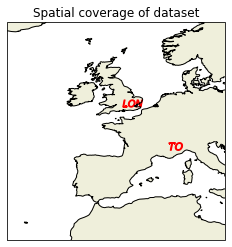

In this notebook we'll illustrate the criticalities of this dataset and our ways to solve them. 

Let's first import some useful packages for handling this tipe of data.

In [ ]:
# ERA5 files are in .nc format
import netCDF4 as nc

# Basic importation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mounting drive for dataset extrapolation
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive/My\ Drive/ML

# Rain data

Rain data are avaiable in form of 'total precipitation', which is the water equivalent precipitation in [*m*]. Rain is usually measured in [*mm*] so we converted by multiplying for 1000. ERA5 allows to download data hourly, so we have to cumulate precipitation over 6 hours manually.

In [ ]:
def get_from_era5_prec(loc, years):
    
    '''
    This function opens the .nc dataset, extracts precipitations and cumulates
    them over 6 hours
    '''

    database = nc.Dataset(f'Dataset/prec_{loc}_{years}.nc')
    dataset = database['tp'][:]
    database.close()
    
    prec = []
    for start, end in zip(range(0, dataset.shape[0], 6), range(6, dataset.shape[0]+6, 6)):
        prec.append(dataset[start:end].sum()*1000)
    
    return np.array(prec)


# Taking precipitations from ERA5
rain_mm_to = get_from_era5_prec('to', 1521)

Now we have to establish a treshold for binarize the rain data in *rain* and *no rain*. Here we have to gather two necessities:

1.   Having a physically effective value
2.   Having a good score in the network

Values of threshold are phisically evaluated by:

*   x < 1mm: no rain
*   1mm < x < 2mm : light rain
*   2mm < x < 6 mm : moderate rain
*   6 mm < x < 10 mm : heavy rain
*   10 mm < x < 30 mm : violent rain
*   x > 30 mm : cloudburst

(Please note that we are talking of mm/6 hours)

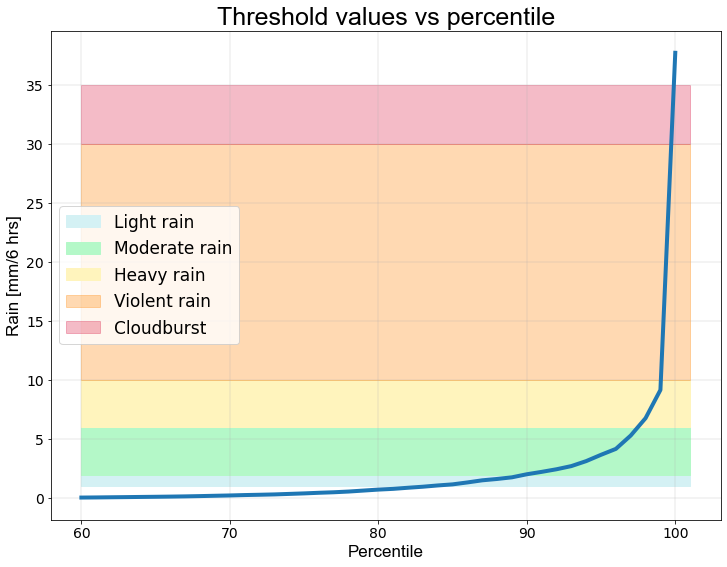

In [ ]:
threshold_to = []

# Evaluating threshold for each percentile 
for i in np.arange(0,101):

  # Defining threshold on precentile
  threshold_to.append(np.percentile(rain_mm_to, i))

# Plotting results
plt.figure(figsize=(12, 9))
plt.plot(np.arange(60,101,1),threshold_to[60:101],linewidth=4)
plt.title('Threshold values vs percentile', family='Arial', size=25)
plt.xlabel('Percentile', family='Arial', size=17)
plt.ylabel('Rain [mm/6 hrs]', family='Arial', size=17)
plt.yticks(range(0, 36, 5), fontsize=14)    
plt.xticks(range(60, 101, 10), fontsize=14)
plt.grid(True,linewidth=0.3)
plt.fill([60., 60., 101., 101.], [1., 2., 2., 1.], color='#D4F1F4',label='Light rain')
plt.fill([60., 60., 101., 101.], [2., 6., 6., 2.], color='#B4F8C8',label='Moderate rain')
plt.fill([60., 60., 101., 101.], [6., 10., 10., 6.], color='#FFF4BD',label='Heavy rain')
plt.fill([60., 60., 101., 101.], [10., 30., 30., 10.], color='#FF8300', alpha=0.3,label='Violent rain')
plt.fill([60., 60., 101., 101.], [30., 35., 35., 30.], color='#DB1F48', alpha=0.3,label='Cloudburst')
plt.legend(prop={'size': 17})  
#plt.savefig('grafici/ThresholdvsPerc.png')  

In [ ]:
# Extrapolating percentile corresponding to a given threshold
to_critical = [next(x for x, val in enumerate(threshold_to) if val > 0.05),
               next(x for x, val in enumerate(threshold_to) if val > 1),
                next(x for x, val in enumerate(threshold_to) if val > 2),
                next(x for x, val in enumerate(threshold_to) if val > 6),
                next(x for x, val in enumerate(threshold_to) if val > 10)]

print(to_critical)

[59, 84, 90, 98, 100]


Limit 0.05 has been arbitrarily choosen in order to have a limit which denotes *potential rain*. Speaking of what is conventionally defined rain, our dataset is highly unbalanced favouring *no rain* labels. Even choosing *light rain* as threshold will result in 88% of *no rain* in each locality.


# Geopotential fields



In [ ]:
norm_met = 1;

def get_from_era5_fields(param, level, years, norm_met):

    '''
    This function opens the .nc dataset, extracts geopotential fields and 
    normalize them with anomaly
    '''
    
    # Importing database
    database = nc.Dataset(f'Dataset/{param}_{level}_{years}.nc')
    
    # Extracting geopotential
    dataset = database[param][:]
    
    # Closing database
    database.close()

    # Normalizing with anomaly
    if norm_met == 1:
      dataset -= dataset.mean(axis=0)
      dataset /= dataset.std(axis=0)

    
    return np.array(dataset)


def get_from_era5_lat(param, level, period):
    
    '''
    This function opens the .nc dataset and extracts latitude
    '''

    # Importing database
    database = nc.Dataset(f'Dataset/{param}_{level}_{years}.nc')
    
    # Extracting latitude
    dataset = database['latitude'][:]
    
    # Closing database
    database.close()
            
    return dataset

def get_from_era5_lon(param, level, period):
    
    '''
    This function opens the .nc dataset and extracts longitude
    '''

    # Importing database
    database = nc.Dataset(f'Dataset/{param}_{level}_{years}.nc')
    
    # Extracting longitude
    dataset = database['longitude'][:]
    
    # Closing database
    database.close()
            
    return dataset


# Defining levels, parameters and years for fields
parameters = ['z', 'z', 'z']
levels = [500, 700, 850]
years = 1521


data = []
# Iterate over the parrallel arrays "parameters" and 'levels' together
for parameter, level in zip(parameters, levels):
    
    # Append extracted data to array
    data.append(get_from_era5_fields(parameter, level, years,norm_met))
  
lat = get_from_era5_lat(parameters[0], levels[0], 1521)
lon = get_from_era5_lon(parameters[0], levels[0], 1521)

Geopotential fields are affected by a structural defect: geopotential is always much higher in the subtropical belt than in the North Pole.

Just have a look at the mean maps, in witch each pixel is averaged on the same pixel in the historical series.

c:\users\jacop\anaconda3\envs\ailab\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\jacop\anaconda3\envs\ailab\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
c:\users\jacop\anaconda3\envs\ailab\lib\site-packages\ipykernel_launcher.py:17:

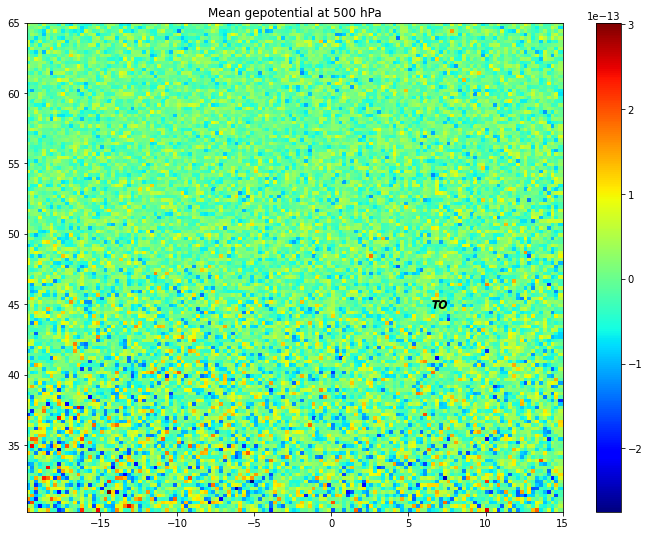

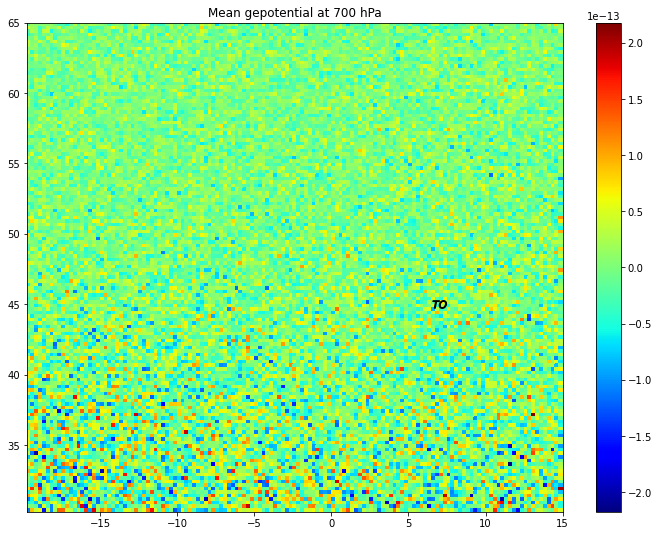

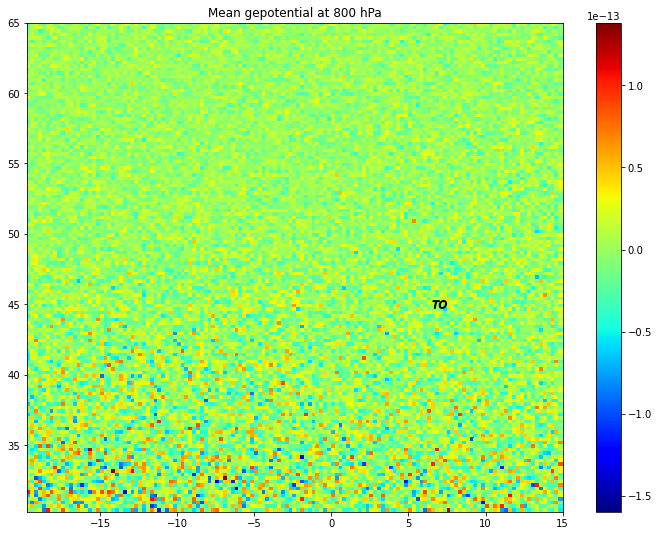

In [ ]:
media = np.mean(data[0], axis = 0)
plt.figure(figsize=(12, 9))
c = plt.pcolor(lon, lat, media, cmap='jet')
plt.title('Mean gepotential at 500 hPa')
plt.scatter(7,45, s=200, color='k', marker="$ TO $")
plt.colorbar(c)

media = np.mean(data[1], axis = 0)
plt.figure(figsize=(12, 9))
c = plt.pcolor(lon, lat, media, cmap='jet')
plt.title('Mean gepotential at 700 hPa')
plt.scatter(7,45, s=200, color='k', marker="$ TO $")
plt.colorbar(c)

media = np.mean(data[2], axis = 0)
plt.figure(figsize=(12, 9))
c = plt.pcolor(lon, lat, media, cmap='jet')
plt.title('Mean gepotential at 800 hPa')
plt.scatter(7,45, s=200, color='k', marker="$ TO $")
plt.colorbar(c)

The problem is: this base structure does not affect precipitations at middle latitudes like in Tourin, but variations in this structure does.

So, here some random plots of geopotential fields for *rain* situations in Tourin.

c:\users\jacop\anaconda3\envs\ailab\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':
c:\users\jacop\anaconda3\envs\ailab\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app
c:\users\jacop\anaconda3\envs\ailab\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have th

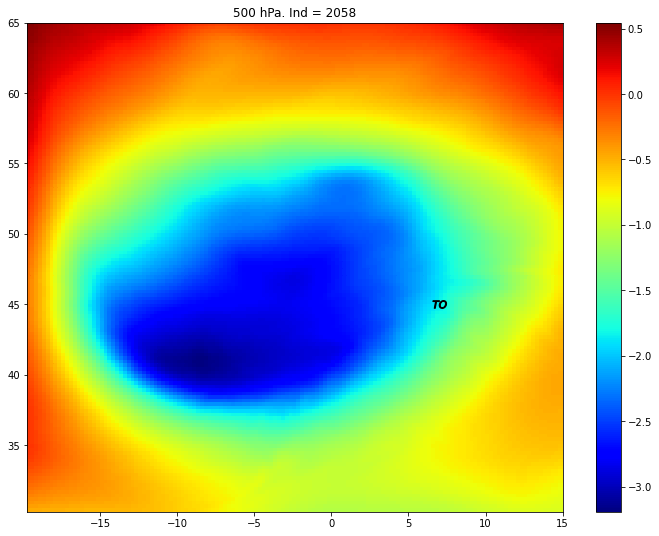

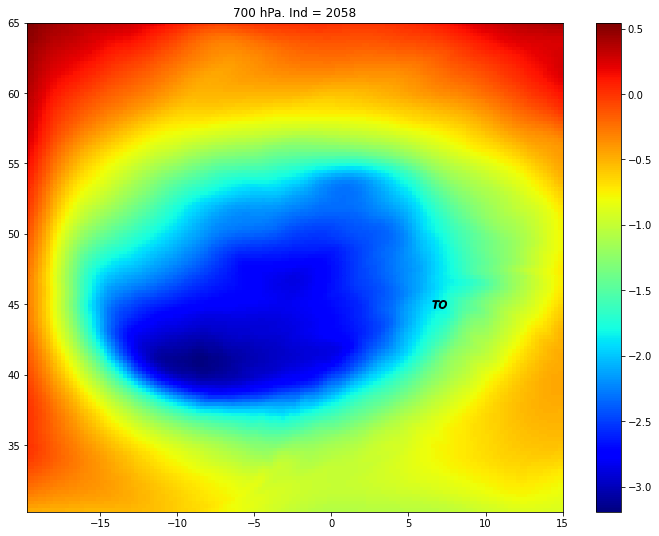

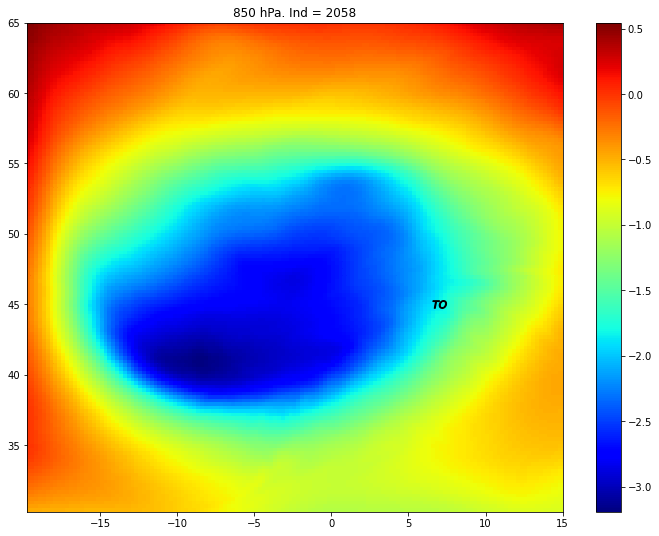

In [ ]:
import random

# Rain in Turin!
r_to = np.where(rain_mm_to > 1)
# Choosing a random one
index_rain_to = random.choice(r_to[0])

plt.figure(figsize=(12, 9))
cr = plt.pcolor(lon, lat, data[0][index_rain_to,:,:], cmap='jet')
plt.scatter(7,45, s=200, color='k', marker="$ TO $")
plt.title('500 hPa. Ind = ' +  str(index_rain_to))
plt.colorbar(cr)

plt.figure(figsize=(12, 9))
cr = plt.pcolor(lon, lat, data[0][index_rain_to,:,:], cmap='jet')
plt.scatter(7,45, s=200, color='k', marker="$ TO $")
plt.title('700 hPa. Ind = ' +  str(index_rain_to))
plt.colorbar(cr)

plt.figure(figsize=(12, 9))
cr = plt.pcolor(lon, lat, data[0][index_rain_to,:,:], cmap='jet')
plt.scatter(7,45, s=200, color='k', marker="$ TO $")
plt.title('850 hPa. Ind = ' +  str(index_rain_to))
plt.colorbar(cr)

This results in the fact that our images in the dataset are very 'similar' and higly correlated, which makes hard to classificate them.



Text(0.5, 1.0, 'Mean correlation of each images with the others')

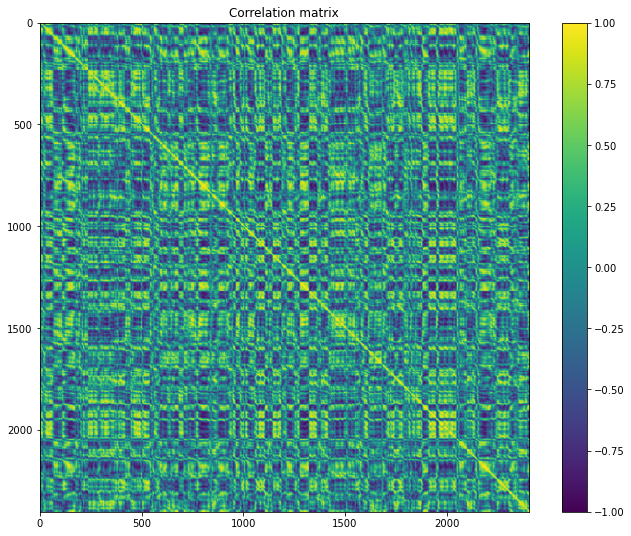

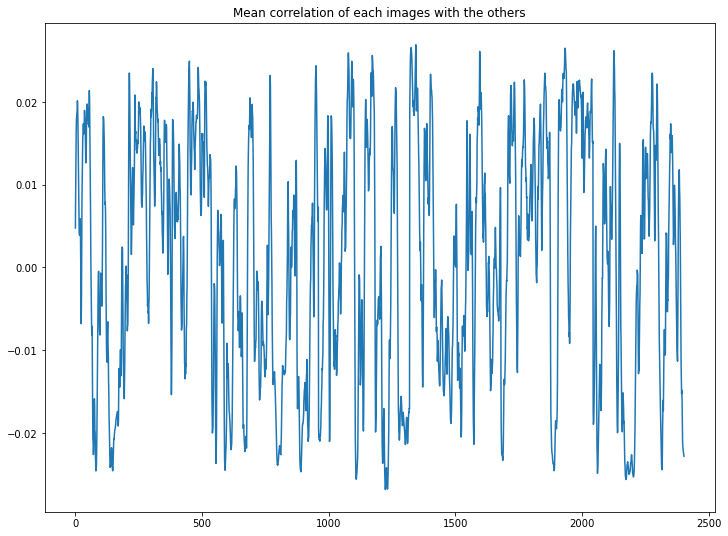

In [ ]:
# Putting images in rows. In columns there are pixel time evolution 
mat = np.reshape(data[0],[2404,140*140])

# Putting images in rcolumns. In rows there are pixel time evolution 
mat = np.transpose(mat)

# Converting in DataFrame for using corr function
mat = pd.DataFrame(mat)

# Computing correlation
a = mat.corr()

# Plot correlation of each images with the others
plt.figure(figsize=(12, 9))
plt.imshow(a,vmin=-1,vmax=1)
plt.title('Correlation matrix')
plt.colorbar()

# How is each image correlate with the other?
plt.figure(figsize=(12, 9))
m = np.mean(a,1)
plt.plot(m)
plt.title('Mean correlation of each images with the others')


Large-scale atmospheric circulation is, in his paths, always very similar. We can observe that there are some anomalous configurations, which pop up with a certain regoularity.

In order to overtake this problem, we decided to normalize geopotential fields each pixel separately. That means that we are now considering geopotential anomaly in each grid point. 

Try setting norm_met = 1 and see the result.

In [ ]:
perc = [59,70,80,84,90,95,98]
perc = np.array(perc)
accuracy_fat = [0.86, 0.85, 0.91, 0.9, 0.92, 0.96, 0.94]
precision_fat = [0.9, 0.76, 0.71, 0.67, 0.48, 0.71, 0.4]
recall_fat = [0.74, 0.75, 0.86, 0.69, 0.61, 0.63, 0.5]
f1_fat = [0.81, 0.75, 0.77, 0.68, 0.54, 0.67, 0.44]


accuracy_thin = [0.85, 0.86, 0.91, 0.92, 0.94, 0.95, 0.96]
precision_thin = [0.87, 0.73, 0.71, 0.74, 0.62, 0.54, 0.75]
recall_thin = [0.75, 0.85, 0.83, 0.71, 0.79, 0.88, 0.75]
f1_thin = [0.8, 0.77, 0.77, 0.72, 0.7, 0.67, 0.75]

plt.figure(figsize=(12, 9))

plt.fill([59., 59., 84., 84.], [0., 1., 1., 0.], color='#D4F1F4')
plt.fill([84., 84., 90., 90.], [0., 1., 1., 0.], color='#B4F8C8')
plt.fill([90., 90., 98., 98.], [0., 1., 1., 0.], color='#FFF4BD')
plt.fill([98., 98., 100., 100.], [0., 1., 1., 0.], color='#FF8300', alpha=0.3)

plt.plot(perc, f1_fat, label = 'F1 - report',linewidth=4, color='k')
plt.plot(perc, f1_thin, label = 'F1 - custom',linewidth=4, color= 'r')

width = 0.5
plt.bar(perc-3*(width/2), precision_fat, label='Precision - report', width=width)
plt.bar(perc-(width/2), precision_thin, label='Precision - custom',width=width)
plt.bar(perc+(width/2), recall_fat, label='Recall - report', width=width)
plt.bar(perc+3*(width/2), recall_thin, label='Recall - custom',width=width)

plt.text(70, 0.97, 'Potential', family='Arial', size=15)
plt.text(86, 0.97, 'Light', family='Arial', size=15)
plt.text(92, 0.97, 'Moderate', family='Arial', size=15)
plt.text(99, 0.97, 'Heavy', family='Arial', size=15)

plt.title('Metrics in Test', family='Arial', size=25)
plt.suptitle('Model: report; locality: Turin', family='Arial', size=20)
plt.xlabel('Precentile', family='Arial', size=17)
plt.ylabel('Metrics', family='Arial', size=17)
plt.yticks(np.arange(0.4, 1.1, 0.1), fontsize=14)    
plt.xticks(range(60, 101, 5), fontsize=14)
plt.ylim([0.3,1])
plt.grid(True,linewidth=0.3)
plt.legend(prop={'size': 17},loc=3)  
plt.savefig('grafici/Valutazioni.png') 